# Imports

In [23]:
import argparse
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.utils as utils
from PIL import Image
import xml.etree.ElementTree as ET
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
import os
import numpy as np


# Bayesian model analysis

<b>WHY:</b><br>
Prior knowlegde improves predictions. We learn.<br>
<br>
<b>HOW:</b><br>
Posterior probability.<br>
This is a summary of how much certainty we have.<br>
<br>
<b>Bayes law:</b><br>
the posterior probability = proportional to the product of the likelihood & prior probability<br>
<br>
<b>Likelyhood:</b><br>
the new data information.<br>
<br>
<b>Prior probability:</b><br>
degree of certainty before data is taken.<br>
state of knowledge.<br>
belief about parameters. Assumptions before any new data is observed.<br>
The initial belief.<br>



https://pi.math.cornell.edu/~mec/2008-2009/TianyiZheng/Bayes.html

## 1 Prior probability

### 1.1 The dataset

- The dataset used in this project i uniform. 
- There are equal amounts of images used for training the model.
- Initially the probabilities are therefore <b>equal</b>.
- The distribution of data is illustrated below:

In [265]:
# Add chart of counts of images per taxon.

### 1.2 Data statistics

- Statistics on occurences of taxon observations in Sweden over a year.
- Artfakta website info.
- Probabilites are no longer uniform.
- Distribution of frequences is shown below.

https://fyndkartor.artfakta.se/searchresults/map?searchParameters=eyJpZCI6MTcxNDY0NTIxNTExMiwic3RhcnREYXRlIjoiMjAyMi0xMi0zMVQyMjowMDowMC4wMDBaIiwiZW5kRGF0ZSI6IjIwMjMtMTItMzBUMjI6MDA6MDAuMDAwWiIsIm5vdGVkIjpmYWxzZSwibm90UmVjb3ZlcmVkIjpmYWxzZSwib25seVZlcmlmaWVkT2JzZXJ2YXRpb25zIjp0cnVlLCJyaXNrTGlzdHMiOlszN119

### get the 2023 observation statistics

In [11]:
observations2023_df = pd.read_csv('observations_2024-05-02 12_21_32.csv', sep=';', encoding='utf-16-le')

In [14]:
observations2023_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1718 entries, 0 to 1717
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TaxonId     1718 non-null   int64  
 1   SortOrder   1718 non-null   int64  
 2   Scientific  1718 non-null   object 
 3   Name        1718 non-null   object 
 4   Time        1718 non-null   object 
 5   NotRedisc   1718 non-null   bool   
 6   Removed     1718 non-null   bool   
 7   Quantity    1718 non-null   int64  
 8   Site        1718 non-null   object 
 9   Observer    1718 non-null   object 
 10  Accuracy    1718 non-null   int64  
 11  Source      1718 non-null   object 
 12  Latitude    1718 non-null   float64
 13  Longitude   1718 non-null   float64
dtypes: bool(2), float64(2), int64(4), object(6)
memory usage: 164.5+ KB


In [15]:
observations2023_df.head(2)

,TaxonId,SortOrder,Scientific,Name,Time,NotRedisc,Removed,Quantity,Site,Observer,Accuracy,Source,Latitude,Longitude
0,261434,55284,Lepomis gibbosus,Solabborre,2023-11-23T00:00:00.0000000+01:00,False,False,1,"Åvarps stenbrott, Sk",Ebbe Berglund,25,Artportalen,56.07772,13.02624
1,219576,97141,Lysichiton americanus,Gul skunkkalla,2023-11-17T13:48:00.0000000+01:00,False,False,3,"Knoppagård, Hl",Via Kent Lindqvist,25,Artportalen,56.78324,12.81643


### show table of counts of observations in Sweden per taxon.

In [17]:
# Group by Scientific column and count frequency, then sort by frequency in descending order
scientific_freq = observations2023_df['Scientific'].value_counts().reset_index()
scientific_freq.columns = ['Scientific', 'Freq']
scientific_freq = scientific_freq.sort_values(by='Freq', ascending=False)

# Calculate total frequency
total_freq = scientific_freq['Freq'].sum()

# Convert DataFrame to list of lists for tabulate
table_data = scientific_freq.values.tolist()

# Add total row
table_data.append(['Total', total_freq])

# Display the table
print(tabulate(table_data, headers=['Scientific', 'Freq'], tablefmt='grid'))


+--------------------------+--------+
| Scientific               |   Freq |
+==========================+========+
| Impatiens glandulifera   |   1155 |
+--------------------------+--------+
| Heracleum mantegazzianum |    379 |
+--------------------------+--------+
| Lysichiton americanus    |     70 |
+--------------------------+--------+
| Alopochen aegyptiaca     |     37 |
+--------------------------+--------+
| Eriocheir sinensis       |     22 |
+--------------------------+--------+
| Nyctereutes procyonoides |     11 |
+--------------------------+--------+
| Elodea nuttallii         |     10 |
+--------------------------+--------+
| Heracleum persicum       |      9 |
+--------------------------+--------+
| Ondatra zibethicus       |      9 |
+--------------------------+--------+
| Ailanthus altissima      |      6 |
+--------------------------+--------+
| Trachemys scripta        |      3 |
+--------------------------+--------+
| Pacifastacus leniusculus |      2 |
+-----------

### 1.3 Calculating prior probability

- calculate first the sum of all observations
- relative freq = sum of all observations / total number of observations
- the relative frequency is the prior probability.

In [267]:
species_names = [
    "Cortaderia jubata",
    "Cardiospermum grandiflorum",
    "Heracleum sosnowskyi",
    "Cenchrus setaceus",
    "Ailanthus altissima",
    "Lysichiton americanus",
    "Hakea sericea",
    "Lygodium japonicum",
    "Microstegium vimineum",
    "Heracleum mantegazzianum",
    "Lespedeza cuneata",
    "Triadica sebifera",
    "Pueraria montana var. Lobata",
    "Prosopis juliflora",
    "Gunnera tinctoria",
    "Baccharis halimifolia",
    "Asclepias syriaca",
    "Heracleum persicum",
    "Ehrharta calycina",
    "Andropogon virginicus"
]

In [19]:
# Calculate total frequency
total_freq = scientific_freq['Freq'].sum()

# Calculate weights based on frequency
weights = scientific_freq['Freq'] / total_freq

# Create a dictionary to store weights for each scientific name
weights_dict = dict(zip(scientific_freq['Scientific'], weights))

# Display the weights
print("Weights based on frequency:")
for scientific, weight in weights_dict.items():
    print(f"{scientific}: {weight:.4f}")

Weights based on frequency:
Impatiens glandulifera: 0.6723
Heracleum mantegazzianum: 0.2206
Lysichiton americanus: 0.0407
Alopochen aegyptiaca: 0.0215
Eriocheir sinensis: 0.0128
Nyctereutes procyonoides: 0.0064
Elodea nuttallii: 0.0058
Heracleum persicum: 0.0052
Ondatra zibethicus: 0.0052
Ailanthus altissima: 0.0035
Trachemys scripta: 0.0017
Pacifastacus leniusculus: 0.0012
Lepomis gibbosus: 0.0006
Oxyura jamaicensis: 0.0006
Rubrivena polystachya: 0.0006
Asclepias syriaca: 0.0006
Acridotheres tristis: 0.0006


### 1.4 Prior probabilites for each taxon

In [ ]:
'''
In Bayesian statistics and machine learning, the prior probability represents your initial belief about the likelihood of different outcomes 
before observing any data. In your image recognition model, you're using the frequencies of scientific names as your prior beliefs about the 
likelihood of encountering each species.
'''

In [20]:
# Create a list of lists containing scientific names, frequencies, and weights
table_data = []
for scientific, freq, weight in zip(scientific_freq['Scientific'], scientific_freq['Freq'], weights):
    table_data.append([scientific, freq, f"{weight:.4f}"])

# Add a header row
headers = ["Scientific", "Freq", "Weight"]

# Display the table using tabulate
print(tabulate(table_data, headers=headers, tablefmt='pretty'))


+--------------------------+------+--------+
|        Scientific        | Freq | Weight |
+--------------------------+------+--------+
|  Impatiens glandulifera  | 1155 | 0.6723 |
| Heracleum mantegazzianum | 379  | 0.2206 |
|  Lysichiton americanus   |  70  | 0.0407 |
|   Alopochen aegyptiaca   |  37  | 0.0215 |
|    Eriocheir sinensis    |  22  | 0.0128 |
| Nyctereutes procyonoides |  11  | 0.0064 |
|     Elodea nuttallii     |  10  | 0.0058 |
|    Heracleum persicum    |  9   | 0.0052 |
|    Ondatra zibethicus    |  9   | 0.0052 |
|   Ailanthus altissima    |  6   | 0.0035 |
|    Trachemys scripta     |  3   | 0.0017 |
| Pacifastacus leniusculus |  2   | 0.0012 |
|     Lepomis gibbosus     |  1   | 0.0006 |
|    Oxyura jamaicensis    |  1   | 0.0006 |
|  Rubrivena polystachya   |  1   | 0.0006 |
|    Asclepias syriaca     |  1   | 0.0006 |
|   Acridotheres tristis   |  1   | 0.0006 |
+--------------------------+------+--------+


### 1.5 Visualising 

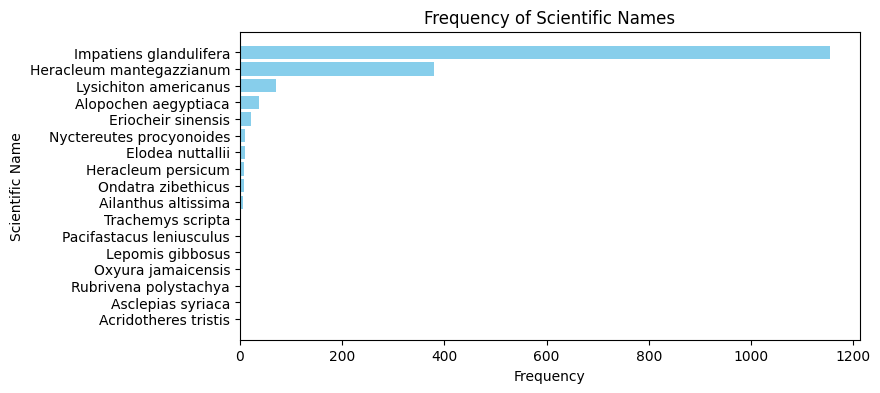

In [22]:
# Plotting
plt.figure(figsize=(8, 4))
plt.barh(scientific_freq['Scientific'], scientific_freq['Freq'], color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Scientific Name')
plt.title('Frequency of Scientific Names')
plt.gca().invert_yaxis()  # Invert y-axis to display highest frequency at the top
plt.show()


## 2 Likelyhood

- This is a multiclass classification problem.
- Deep learning with neural networks.
- The likelyhood function therefore is = likelyhood of observing the true labels given the models predictions.
- Indirectly inferred from the 'cross entropy loss' function = measures the dissimilarity between the predicted probability distribution.
- interpreted as a negative log-likelyhood.
- when training the model want s to minimize loss, which maximizes likelyhood.

In [271]:
# table with statistics:
# mean loss for all models.
# min and max loss for all models.

In [30]:
import torch

# Define the path to the checkpoint file
checkpoint_path = "/path/to/your/checkpoint.pth"  # Replace with the actual path to your checkpoint file

# Load the checkpoint file
checkpoint = torch.load(checkpoint_path)

# Print the keys of the checkpoint dictionary
print(checkpoint.keys())


FileNotFoundError: [Errno 2] No such file or directory: '/path/to/your/checkpoint.pth'

In [28]:
import torch

def load_loss(filepath):
    # Load the model checkpoint
    checkpoint = torch.load(filepath)
    
    # Extract the loss from the checkpoint using the correct key
    loss = checkpoint['your_loss_key']
    
    return loss


In [29]:
# Define the directory where the model files are saved
models_directory = "../Model_training_testing/models/"

# Initialize lists to store the losses from all models
all_losses = []

# Loop through each model file in the directory
for filename in os.listdir(models_directory):
    if filename.endswith(".pth"):
        # Load the model and extract the loss
        model_loss = load_loss(os.path.join(models_directory, filename))
        all_losses.extend(model_loss)
        
# Convert the list of losses to a NumPy array for easy computation
all_losses = np.array(all_losses)

# Calculate statistics
mean_loss = np.mean(all_losses)
min_loss = np.min(all_losses)
max_loss = np.max(all_losses)

# Print the statistics
print("Statistics for all models:")
print(f"Mean Loss: {mean_loss:.4f}")
print(f"Min Loss: {min_loss:.4f}")
print(f"Max Loss: {max_loss:.4f}")


KeyError: 'your_loss_key'

In [272]:
# visualize:
# loss distribution
# loss convergence

Text about comparison of models.

## 3 Weights based on posterior probabilities

Explain how we set the weights before training.

## 4 Modelling

- 1 We train all models by themselves first. Each model trained on only images of the specific taxon. Until a certain loss threshold.
<br><br>
- 2 We combine the models to an ensemble model. We set weights based on the posterior probability. The run on test data.
<br><br>
- 3 We are using weighted averaging to estimate the predictions. This incorporates uncertainty of each model.


### 4.1 Individual models

- a: get images
- b: split data set into training, val, test
    - Training images are 80%
    - Validation images are 20%
    - Testing images are 20%.
- c: collect labels
- d: model architecture
    - vgg16 pretrained plus other layers.
    - optimizer = optim.Adam(model.parameters(), lr=0.001)
    - criterion = nn.CrossEntropyLoss()
    - lr=0.001
- e: training loop
    - early stopping
    - save loss and accuracies
- f: save model and model data.

### 4.1.1 Generic model code

In [273]:
# Define the transformations for data augmentation
train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=10),  # Rotate the image by up to 10 degrees
    transforms.RandomHorizontalFlip(p=0.5),  # Flip the image horizontally with a probability of 0.5
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Adjust brightness, contrast, saturation, and hue
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),  # Crop a random portion of the image and resize it to 224x224
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

In [274]:
class PlantDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Collect paths of all image files directly from the root directory
        label = os.path.basename(root_dir)  # Get the label from the root directory name
        label_images = [f for f in os.listdir(root_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        self.image_paths.extend([os.path.join(root_dir, img) for img in label_images])
        self.labels.extend([label] * len(label_images))  # Assign the folder name as the label

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


#### 4.1.1a <span style="color:red">Cortaderia jubata & Cardiospermum grandiflorum</span>

In [275]:
# Define the path to the root directory containing the images
root_dir1 = r'C:\Users\asche\OneDrive\Skrivebord\invasive_plant_classifier\Downloading_images\data\Cortaderia jubata'
root_dir2 = r'C:\Users\asche\OneDrive\Skrivebord\invasive_plant_classifier\Downloading_images\data\Cardiospermum grandiflorum'

In [276]:
# Create the dataset instance with the appropriate root directory and transformations
dataset = PlantDataset(root_dir=root_dir2, transform=train_transforms)

TypeError: scandir: path should be string, bytes, os.PathLike or None, not list

In [ ]:
print(len(dataset))

98


In [ ]:
# Define the sizes of subsets for training, validation, and test sets
train_size = int(0.6 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size

# Create subsets for training, validation, and test sets
train_subset_indices = torch.randperm(len(dataset))[:train_size]
val_subset_indices = torch.randperm(len(dataset))[train_size:train_size+val_size]
test_subset_indices = torch.randperm(len(dataset))[train_size+val_size:]

train_subset = Subset(dataset, train_subset_indices)
val_subset = Subset(dataset, val_subset_indices)
test_subset = Subset(dataset, test_subset_indices)

In [ ]:
# Create DataLoader instances for subsets
batch_size = 1
train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

# Print the lengths of DataLoader instances
print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))

58
20
20


In [ ]:
unique_labels = set()

# Iterate over the training dataset
for _, label in train_dataloader:
    unique_labels.add(label[0])  # Extract the label string from the tuple

# Iterate over the validation dataset
for _, label in val_dataloader:
    unique_labels.add(label[0])  # Extract the label string from the tuple

# Iterate over the test dataset
for _, label in test_dataloader:
    unique_labels.add(label[0])  # Extract the label string from the tuple

# Calculate the number of unique classes
num_classes = len(unique_labels)

# Print the unique plant names
print("Unique Plant Names:", unique_labels)
print("Number of Unique Classes:", num_classes)

Unique Plant Names: {'Cardiospermum grandiflorum'}
Number of Unique Classes: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


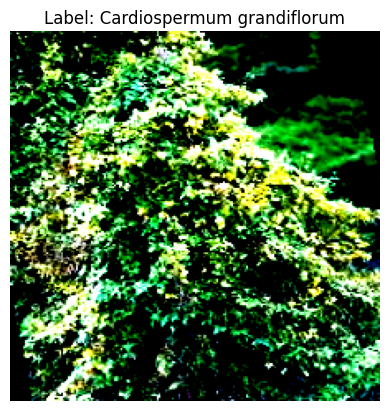

In [ ]:
import random

# Iterate over the train_dataloader to select a random batch
for images, labels in train_dataloader:
    # Select a random index within the batch size
    batch_size = images.size(0)
    random_index = random.randint(0, batch_size - 1)
    
    # Retrieve the random image and its label from the batch
    random_image = images[random_index]
    random_label = labels[random_index]

    # Visualize the random image along with its label
    plt.imshow(random_image.permute(1, 2, 0))  # Permute dimensions for plotting
    plt.title(f"Label: {random_label}")
    plt.axis('off')
    plt.show()

    # Break the loop after inspecting one batch
    break


In [ ]:
class PlantClassifier(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(PlantClassifier, self).__init__()
        # Define convolutional blocks
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Add dropout after ReLU
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Add dropout after ReLU
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Add dropout after ReLU
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Define fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(64 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Add dropout after ReLU
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Forward pass through convolutional blocks
        x = self.conv_block(x)
        # Flatten the output for fully connected layer
        x = x.view(-1, 64 * 28 * 28)  # Adjust based on final feature map size
        # Pass through fully connected layer
        out = self.fc(x)
        return out

# Define your own classifier and its optimizer and loss function
model = PlantClassifier(num_classes=num_classes, dropout_rate=0.5)  # Adjust dropout rate as needed
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [ ]:
''' model with vgg16

import torch.nn as nn

class PlantClassifier(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(PlantClassifier, self).__init__()
        # Define convolutional blocks
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Add dropout after ReLU
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Add dropout after ReLU
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Add dropout after ReLU
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Define fully connected layers
        self.fc = nn.Linear(64 * 28 * 28, num_classes)  # Adjust input size based on final feature map size

    def forward(self, x):
        # Forward pass through convolutional blocks
        x = self.conv_block(x)
        # Flatten the output for fully connected layer
        x = x.view(-1, 64 * 28 * 28)  # Adjust based on final feature map size
        # Pass through fully connected layer
        out = self.fc(x)
        return out

# Load pre-trained VGG16 model
vgg16 = models.vgg16()

# Modify the fully connected layer for plant classification
vgg16.classifier[-1] = nn.Linear(in_features=4096, out_features=num_classes)

# Optionally freeze pre-trained layers
# for param in vgg16.features.parameters():
#     param.requires_grad = False

# Define your own classifier and its optimizer and loss function
model = PlantClassifier(num_classes=num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Combine VGG16 convolutional base with your custom classifier
class CombinedModel(nn.Module):
    def __init__(self, vgg, custom_classifier):
        super(CombinedModel, self).__init__()
        self.vgg = vgg.features  # Only taking the convolutional layers
        self.custom_classifier = custom_classifier

    def forward(self, x):
        x = self.vgg(x)
        x = x.view(x.size(0), -1)
        x = self.custom_classifier(x)
        return x

# Instantiate the combined model
combined_model = CombinedModel(vgg16, model)

# Define optimizer and loss function for the combined model
optimizer = optim.Adam(combined_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

'''

' model with vgg16\n\nimport torch.nn as nn\n\nclass PlantClassifier(nn.Module):\n    def __init__(self, num_classes, dropout_rate=0.5):\n        super(PlantClassifier, self).__init__()\n        # Define convolutional blocks\n        self.conv_block = nn.Sequential(\n            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),\n            nn.ReLU(),\n            nn.Dropout(dropout_rate),  # Add dropout after ReLU\n            nn.MaxPool2d(kernel_size=2, stride=2),\n            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),\n            nn.ReLU(),\n            nn.Dropout(dropout_rate),  # Add dropout after ReLU\n            nn.MaxPool2d(kernel_size=2, stride=2),\n            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),\n            nn.ReLU(),\n            nn.Dropout(dropout_rate),  # Add dropout after ReLU\n            nn.MaxPool2d(kernel_size=2, stride=2)\n        )\n        # Define full

In [ ]:
# Define the number of epochs and early stopping parameters
num_epochs = 25
patience = 3  # Number of epochs to wait for improvement
best_val_loss = float('inf')
early_stopping_counter = 0

# Lists to store training and validation losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0

    # Create a mapping from unique labels to numerical indices
    label_to_index = {label: index for index, label in enumerate(unique_labels)}

    # Training loop
    for images, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        
        # Extract the string label from the tuple and convert to numerical index
        label_index = label_to_index[labels[0]]
        
        # Convert numerical index to tensor
        labels = torch.tensor([label_index], dtype=torch.long)  # Ensure the labels tensor has batch size 1
        
        loss = F.cross_entropy(outputs, labels)
        train_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train_predictions += (predicted == labels).sum().item()
        total_train_predictions += labels.size(0)

        loss.backward()
        optimizer.step()


    # Calculate average training loss and accuracy
    train_loss /= len(train_dataloader)
    train_accuracy = correct_train_predictions / total_train_predictions

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0

    label_to_index = {label: index for index, label in enumerate(unique_labels)}

    with torch.no_grad():
        for images, labels_tuple in val_dataloader:  # Unpack the labels tuple
            outputs = model(images)
            
            # Extract the label from the tuple
            labels = labels_tuple[0]  # Assuming the label is the first element in the tuple
            
            # Convert the label to its corresponding index
            label_index = label_to_index[labels]
            
            # Convert label index to tensor
            labels = torch.tensor([label_index], dtype=torch.long)
            
            loss = F.cross_entropy(outputs, labels)
            val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val_predictions += (predicted == labels).sum().item()
            total_val_predictions += labels.size(0)


    # Calculate average validation loss and accuracy
    val_loss /= len(val_dataloader)
    val_accuracy = correct_val_predictions / total_val_predictions

    # Save training and validation losses and accuracies
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Check for early stopping based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    # Print training and validation loss and accuracy
    print(f'Epoch {epoch}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, '
    f'Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')


Epoch 0, Training Loss: 0.0000, Validation Loss: 0.0000, Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 1, Training Loss: 0.0000, Validation Loss: 0.0000, Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 2, Training Loss: 0.0000, Validation Loss: 0.0000, Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Early stopping at epoch 3


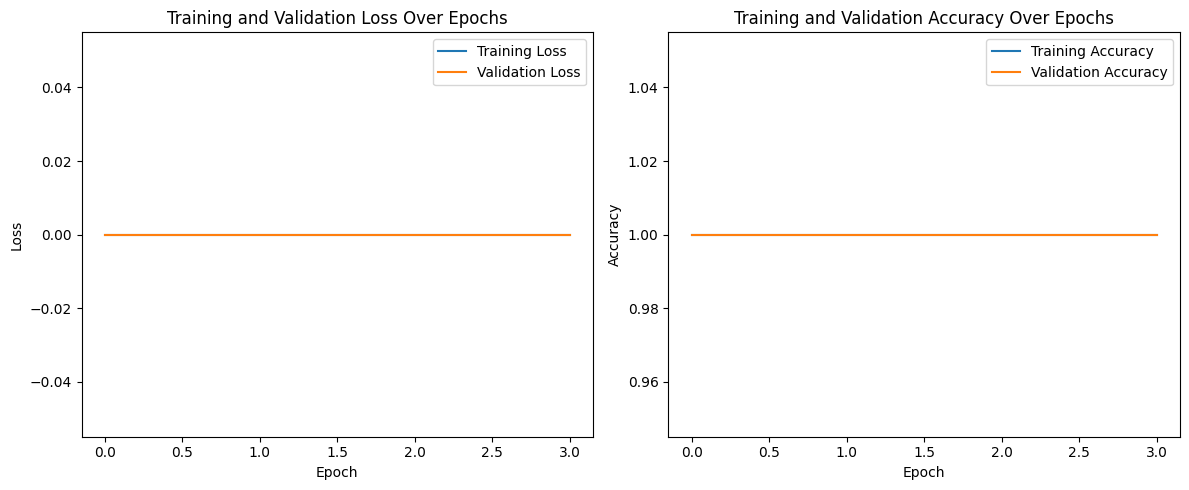

In [ ]:
# Plotting training and validation losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()

# Plotting training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Testing phase
model.eval()
test_loss = 0.0
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for images, labels_tuple in test_dataloader:  # Assuming you have a separate test dataloader
        outputs = model(images)
        
        # Extract the label from the tuple
        labels = labels_tuple[0]  # Assuming the label is the first element in the tuple
        
        # Convert the label to its corresponding index
        label_index = label_to_index[labels]
        
        # Convert label index to tensor
        labels = torch.tensor([label_index], dtype=torch.long)
        
        # Calculating loss
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)  # Get the index of the maximum output
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

# Calculate average test loss
test_loss /= len(test_dataloader)

# Calculate accuracy
accuracy = correct_predictions / total_predictions

# Print test loss and accuracy
print(f'Test Loss: {test_loss}, Accuracy: {accuracy * 100:.2f}%')


Test Loss: 0.0, Accuracy: 100.00%


In [ ]:
torch.save(model.state_dict(), 'combined.pth')

### 4.2 Ensemble model

In [ ]:
# Load the models
model_cortaderia = PlantClassifier(num_classes=1)  # Load model for Cortaderia jubata
model_cortaderia.load_state_dict(torch.load('Cortaderia jubata.pth'))
model_cortaderia.eval()

model_cardiospermum = PlantClassifier(num_classes=1)  # Load model for Cardiospermum grandiflorum
model_cardiospermum.load_state_dict(torch.load('Cardiospermum grandiflorum.pth'))
model_cardiospermum.eval()

# Define a function to make predictions using both models and combine them
def ensemble_predict(image):
    with torch.no_grad():
        # Predictions from the first model
        output_cortaderia = model_cortaderia(image)
        prob_cortaderia = F.softmax(output_cortaderia, dim=1)

        # Predictions from the second model
        output_cardiospermum = model_cardiospermum(image)
        prob_cardiospermum = F.softmax(output_cardiospermum, dim=1)

        # Combine predictions (e.g., by averaging probabilities)
        combined_prob = 0.5 * (prob_cortaderia + prob_cardiospermum)  # Example: Simple average

        # Get the final prediction
        _, predicted_label = torch.max(combined_prob, 1)
        return predicted_label.item()


In [ ]:
# Define the transformations for preprocessing the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to match the input size of the models
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

# Define a dictionary mapping numeric labels to species names
label_to_species = {
    0: "Cortaderia jubata",
    1: "Cardiospermum grandiflorum"
}

image_path1 = '../Downloading_images/data/Cortaderia jubata/11.jpeg'
image_path2 = '../Downloading_images/data/Cardiospermum grandiflorum/11.jpg'
image = Image.open(image_path2)
image = transform(image).unsqueeze(0)  # Add a batch dimension


# Use the ensemble_predict function to make predictions
predicted_label = ensemble_predict(image)
predicted_species = label_to_species[predicted_label]

print("Ensemble Predicted Species:", predicted_species)


Ensemble Predicted Species: Cortaderia jubata


###  4.3 Weighted averaging predictions